In [8]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import datetime
import datetime as dt
import numpy as np
import random
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
#from matplotlib.ticker import PercentFormatter
from scipy.stats import norm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sns.set_style("ticks")

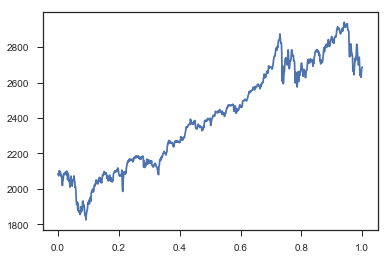

In [39]:
#### Reading in Euro/Dollar Exchange Quotes
euro1 = pd.read_csv("eurcsv.csv")
jpy1 = pd.read_csv("jpy.csv")
#crude1  = pd.read_csv("Crude.csv")
#intc1 = pd.read_csv("intc.csv")
#nflx1 = pd.read_csv("nflx.csv")
emini1 = pd.read_csv("e-mini.csv")


#Defining Dates and Closing Prices
euro = euro1['Price']
jpy = jpy1['Price']
#crude = crude1['Price']
#intc = intc1["Adj Close"]
#nflx = nflx1["Adj Close"]
e_mini = emini1['Price']
x = np.linspace(0,1,814)
plt.plot(x,e_mini)


In [40]:
#Stru

def zero(basket):
    data  = np.copy(basket)
    hold = []
    for i in range(len(data)):
        lens = len(data[i])
        hold.append(lens)
    max_length = np.max(hold)
    for i in range(len(data)):
        while len(data[i]) <= max_length-1:
            replaced = np.insert(data[i],len(data[i]),0)
            data[i] = replaced
    stacked = np.column_stack(data)
    return stacked


def combine(structured_rets):
    combined_returns = []
    for i in range(len(structured_rets)):
        num_zeros = (structured_rets[[i],:] == 0).sum()
        column_sum = sum(structured_rets[i])
        length = len(structured_rets[i])
        average = column_sum/(length)
        combined_returns.append(average)
    
    running_sum = np.cumsum(combined_returns)
    return combined_returns



In [41]:
def tester(price_in,technical,long_or_short): #May want to call this MacDTester so we can keep track of different technical indicators
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    twenty_six = price_in.ewm(span=26).mean()
    twelve = price_in.ewm(span=12).mean()
    macd = twelve - twenty_six
    delta_macd = macd.pct_change(periods=2)
    slope = []
#     for i in range(len(macd)):
#         if i == 0:
#             slope.append(i)
#         else:
#             temp_slope = macd[i]-macd[i-1]
#             slope.append(temp_slope)
    if long_or_short == "long":
        for i in range(len(price_in)-1):
            if delta_macd[i] > technical:
                buys.append(i)
    else:
        for i in range(len(price_in)-1):
            if delta_macd[i] < technical:
                shorts.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
    
#    plt.plot(np.cumsum(rets))
    if long_or_short == "long":
        total_return = np.cumsum(rets)
        std_rets = np.std(rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_rets))*-1
        end_return = (end_return1)/VAR_95
        
    else:
        total_return = np.cumsum(s_rets)
        end_return = total_return[-1]
        std_s_rets = np.std(s_rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(s_rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_s_rets))*-1
        end_return = (end_return1)/VAR_95

    max_macd = np.percentile(delta_macd[5:],85)
    min_macd = np.percentile(delta_macd[5:],15)

    return end_return, total_return, min_macd, max_macd



def random_walker(n,ls,close):
    starter = [0]    
    x_start, indicator, min_ind, max_ind = tester(close,starter[-1],str(ls))
    for i in range(n):
        test_x = np.random.uniform(min_ind,max_ind)
        random_return, indicator, minn,maxx = tester(close,test_x,str(ls))
        test_return, notimportant, minn,maxx = tester(close,starter[-1],str(ls))
        if random_return > test_return:
            starter.append(test_x)
    x,y,minn,maxx = tester(close,starter[-1],str(ls))
        
    return starter[-1]

In [42]:
def back_testing(price_in,long_indicator,short_indicator):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    twenty_six = price_in.ewm(span=26).mean()
    twelve = price_in.ewm(span=12).mean()
    macd = twelve - twenty_six
    delta_macd = macd.pct_change(periods=2)
    mix = []
    mix_port = []
    slope = []
    for i in range(len(macd)):
        if i == 0:
            slope.append(i)
        else:
            temp_slope = macd[i]-macd[i-1]
            slope.append(temp_slope)

    for i in range(len(price_in)-1):
        if delta_macd[i] > long_indicator:
            buys.append(i)
            mix.append(i)
        elif delta_macd[i] < short_indicator:
            shorts.append(i)
            mix.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
#     for i in mix:
#         j = int(i)
#         j1 = int(i+1)
#         mix_return = ((price_in[j1] - price_in[j])/price_in[j])*100
#         mix_port.append(mix_return)        
        
#     for i in range(len(price_in)-1):
#         z = int(i)
#         z1 = int(i+1)
#         base = ((price_in[z1] - price_in[z])/price_in[z])*100
#         benchmark.append(base)

#     x_bench = np.linspace(0,1,len(benchmark))
    x_strat = np.linspace(0,1,len(rets))   
    x_short = np.linspace(0,1,len(s_rets))
    mix_port = np.concatenate((rets,s_rets))
    x_mix = np.linspace(0,1,len(mix_port))
#    fig, ax = plt.subplots(figsize=(12,5))

#     ax.plot(x_strat, np.cumsum(rets),label="Long Strategy")
#     ax.plot(x_bench, np.cumsum(benchmark),label="Benchmark")
#     ax.plot(x_short, np.cumsum(s_rets),label="Short Strategy")
#     ax.plot(x_mix, np.cumsum(mix_port),label="Mix Portfolio")

# #    ax2 = ax.twinx()
# #    ax2.plot(np.linspace(0,1,len(macd)), macd, 'r')
#     ax.yaxis.set_major_formatter(PercentFormatter())    
#     ax.legend(fontsize=15)
#     print("Strategy Return = %",sum(rets))
#     print("Total Return Outright = %",sum(benchmark))
    
#     #RISK ASSESMENT BENCHMARK
#     delta_returns = price_in.pct_change()
#     mean_returns = np.mean(delta_returns)
#     std_returns = np.std(delta_returns)
#     VAR_95 = norm.ppf(1-0.95,mean_returns, std_returns)*100
#     print("Benchmark VAR @ confidence Level = 95% Level", VAR_95)
    
#     #RISK ASSESMENT STRATEGY
#     #delta_returns_strat = price_in.pct_change()
#     mean_returns_strat = np.mean(rets)
#     std_returns_strat = np.std(rets)
#     VAR_95_strat = norm.ppf(1-0.95,mean_returns_strat, std_returns_strat)
#    print("Strategy VAR @ confidence Level = 95% Level", VAR_95_strat)
    return mix_port

    

In [43]:
import quandl
quandl.ApiConfig.api_key = "NbXifkuiz3ymhZj7V8-E"
aapl1 = quandl.get("WIKI/AAPL", start_date="2014-10-17", end_date="2018-11-15")
curr = quandl.get("FED/RXI_N_A_SZ")
SP = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", start_date="2014-10-17", end_date="2018-11-15")

len(curr)

48

544


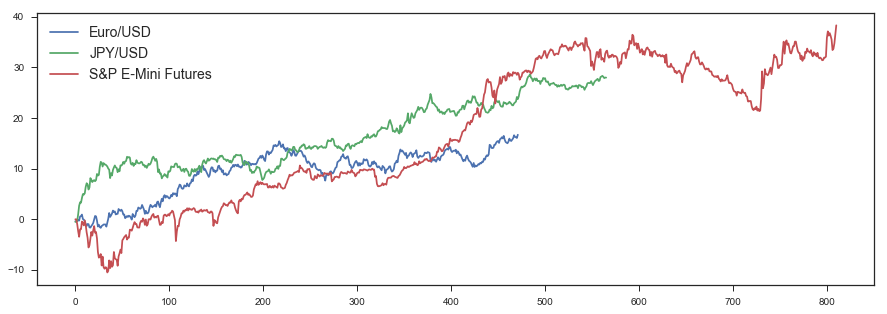

In [44]:
#labels = ("Euro/USD","NFLX","USD/JPY","Crude","E-Mini")
def best_indicator(n,prices,labels):
    long_ind = random_walker(n,"long",prices)
    short_ind = random_walker(n,"short",prices)
    returns = back_testing(prices,long_ind,short_ind)
    plt.plot(np.cumsum(returns),label=labels)
    plt.legend(fontsize=14)
    return returns
plt.figure(figsize=(15,5))

euro_returns = best_indicator(150,euro,"Euro/USD")
#nflx_returns = best_indicator(150,nflx,"NFLX")
#intc_returns = best_indicator(100,intc)
jpy_returns = best_indicator(150,jpy,"JPY/USD")
#crude_returns = best_indicator(150,crude,"Crude")
e_mini_returns = best_indicator(150,e_mini,"S&P E-Mini Futures")


print(len(euro))

-0.6665472779369628
82.00991044776119
0.3899241237545641
-0.21728850427956675
-2.3555239038890265
-0.9665899761652542
29.734992679355784
-1.1828206329301751
0.7875130018722697
-2.985346503302754
-1.9047707231040563
0.6496679239893269
-0.2642860830576527
0.8027861659445152
-1.2258727626869643
2.072338016207226
-0.03147378617923716
-1.5597901969190668
-2.4370522710108937
-0.19882589578070917
-2.5592064386550493
-1.1051424251246749
-10.350836562468226
1.084939234838041
-0.5832170152954153
-1.1293456374818265
2.90347513267717
-5.023914225309574
-1.7761598871040163
-2.1763376781658317
-0.8417992911392433
-1.8803243591002576
-1.2321077406754182
13.409610250934332
-1.3365678346810421
5.35444653412144
-1.7429007494358368
-1.9016992472885332
-1.8044580312154357
-1.2768761904761905
7.539031029480606
-1.4734658052361207
-0.8366848394063959
-0.5991884214797782
13.845381526104418
-2.5353521512743216
-0.6727207498094084
0.21486731449288266
-1.9273031433885892
-4.685513404098236
-0.8893785245952904
0

C:\Users\Dan\Documents\Programming\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()



-0.9755494897595091
-3.9992776306284616
-8.838995983935742
-0.40760981777119576
-0.3948869936034114
-4.580966466662928
-1.2146751910206988
-1.8448355335939228
-2.911611009894941
-0.5725058996545709
-9.102382186084206
0.07530784827654424
-1.038825969948419
14.141630901287554
-1.4199051490514905
-7.277703793771191
-0.8606849105120652
-1.0587045667660355
24.0029744199881
-1.4814319809069214
0.9139259612329199
-2.040626210958692
-2.7550053628888094
-0.8104724636208094
2.871327449354342
-1.4821004294983096
3.8085136573252916
-0.0194295368713973
3.96322145146792
-1.4550905329710648
-0.3969914242863389
-1.083998861996789
-15.263623326959848
-0.6624927090184788
0.5824674484456198
-0.9839874771209405
43.994757688723205
-1.3979140108934986
-2.61447889650189
-1.1718350893997445
-8.004053271569196
-2.0813313560718405
-2.0044022242817428
-1.5502094336186487
-1.1909386716878914
-3.7487287645903162
-2.547421682691296
-0.17808740310999102
-2.069699066067105
2.1387618387618383
-0.8942157080754296
-2.6

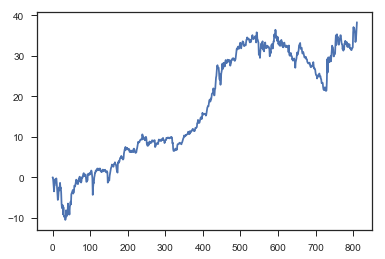

In [16]:
plt.plot(np.cumsum(e_mini_returns))
for i in range(len(e_mini_returns)-1):
    x = ((e_mini_returns[i+1]-e_mini_returns[i])/e_mini_returns[i])
    print(x)

In [17]:
port_returns = (euro_returns,nflx_returns,jpy_returns,crude_returns,e_mini_returns)
structured_returns = zero(port_returns)
total_returns = combine(structured_returns)
cum_returns = np.cumsum(total_returns)

plt.figure(figsize=(14,4))

plt.plot(np.cumsum(total_returns))
roi = cum_returns[-1]/(len(cum_returns)/253)
print(cum_returns[-1])
print(roi)


NameError: name 'nflx_returns' is not defined

NameError: name 'date' is not defined

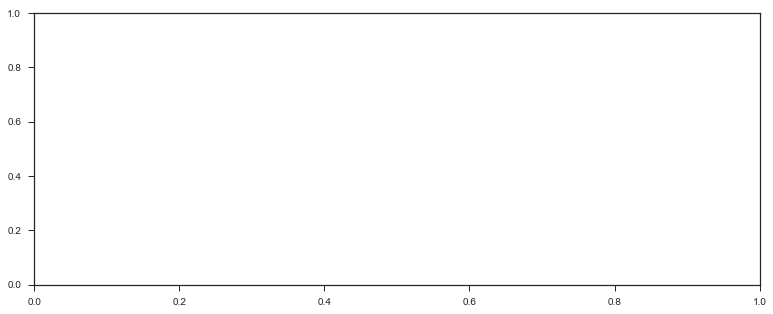

In [18]:
# date = pd.to_datetime(sp['Date'])
fig, ax1 = plt.subplots(figsize=(13,5))
ax1.plot(date, macd, 'b-')
ax2 = ax1.twinx()
ax2.plot(date, close, 'r')
ax2.set_ylabel(color='r')
ax2.tick_params('y', colors='r')
fig.tight_layout()

# Short Moving Average/Long Moving Average Indicator

In [59]:
def SMALMAtester(price_in,SMA_ind,LMA_ind,long_or_short):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    LMA = price_in.rolling(window=LMA_ind).mean()
    SMA = price_in.rolling(window=SMA_ind).mean()
    diff = SMA - LMA
    delta_MA = diff.pct_change(periods=2)
    slope = []
#     for i in range(len(macd)):
#         if i == 0:
#             slope.append(i)
#         else:
#             temp_slope = macd[i]-macd[i-1]
#             slope.append(temp_slope)
    if long_or_short == "long":
        for i in range(len(price_in)-1):
            if diff[i] > 0:
                buys.append(i)
    else:
        for i in range(len(price_in)-1):
            if diff[i] < 0:
                shorts.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
    
#    plt.plot(np.cumsum(rets))
    if long_or_short == "long":
        total_return = np.cumsum(rets)
        std_rets = np.std(rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_rets))*-1
        end_return = (end_return1)/VAR_95
        
    else:
        total_return = np.cumsum(s_rets)
        end_return = total_return[-1]
        std_s_rets = np.std(s_rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(s_rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_s_rets))*-1
        end_return = (end_return1)/VAR_95

    max_SMA = 50
    min_SMA = 5
    max_LMA = 200
    min_LMA = 50

    return end_return, total_return, max_SMA, min_SMA,max_LMA ,min_LMA


In [60]:
#### We will need another version to vary the window instead of the indicator level

def random_walkerSMALMA(n,ls,close):
    starter = [5] 
    starter2 = [50] #will need two starters to make this work and update functions and the like
    x_start, indicator, max_SMA, min_SMA,max_LMA ,min_LMA = SMALMAtester(close,starter[-1],starter2[-1],str(ls))
    for i in range(n):
        test_SMA = np.random.randint(min_SMA,max_SMA)
        test_LMA = np.random.randint(min_LMA,max_LMA)
        random_return, indicator, max_SMA, min_SMA,max_LMA ,min_LMA = SMALMAtester(close,test_SMA,test_LMA,str(ls))
        test_return, notimportant, max_SMA, min_SMA,max_LMA ,min_LMA = SMALMAtester(close,starter[-1],starter2[-1],str(ls))
        if random_return > test_return:
            starter.append(test_SMA)
            starter2.append(test_LMA)
    #x,y,minn,maxx = tester(close,starter[-1],starter2[-1],str(ls))
        
    return starter[-1] , starter2[-1]

In [61]:
def back_testingSMALMA(price_in,SMA_ind,LMA_ind,SMA_indshort,LMA_indshort):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    LMA = price_in.rolling(window=LMA_ind).mean()
    SMA = price_in.rolling(window=SMA_ind).mean()
    diff = SMA - LMA
    delta_MA = diff.pct_change(periods=2)
    mix = []
    mix_port = []
    slope = []
    for i in range(len(diff)):
        if i == 0:
            slope.append(i)
        else:
            temp_slope = diff[i]-diff[i-1]
            slope.append(temp_slope)

    for i in range(len(price_in)-1):
        if diff[i] > 0:
            buys.append(i)
            mix.append(i)
        elif diff[i] < 0:
            shorts.append(i)
            mix.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
#     for i in mix:
#         j = int(i)
#         j1 = int(i+1)
#         mix_return = ((price_in[j1] - price_in[j])/price_in[j])*100
#         mix_port.append(mix_return)        
        
#     for i in range(len(price_in)-1):
#         z = int(i)
#         z1 = int(i+1)
#         base = ((price_in[z1] - price_in[z])/price_in[z])*100
#         benchmark.append(base)

#     x_bench = np.linspace(0,1,len(benchmark))
    x_strat = np.linspace(0,1,len(rets))   
    x_short = np.linspace(0,1,len(s_rets))
    mix_port = np.concatenate((rets,s_rets))
    x_mix = np.linspace(0,1,len(mix_port))
#    fig, ax = plt.subplots(figsize=(12,5))

#     ax.plot(x_strat, np.cumsum(rets),label="Long Strategy")
#     ax.plot(x_bench, np.cumsum(benchmark),label="Benchmark")
#     ax.plot(x_short, np.cumsum(s_rets),label="Short Strategy")
#     ax.plot(x_mix, np.cumsum(mix_port),label="Mix Portfolio")

# #    ax2 = ax.twinx()
# #    ax2.plot(np.linspace(0,1,len(macd)), macd, 'r')
#     ax.yaxis.set_major_formatter(PercentFormatter())    
#     ax.legend(fontsize=15)
#     print("Strategy Return = %",sum(rets))
#     print("Total Return Outright = %",sum(benchmark))
    
#     #RISK ASSESMENT BENCHMARK
#     delta_returns = price_in.pct_change()
#     mean_returns = np.mean(delta_returns)
#     std_returns = np.std(delta_returns)
#     VAR_95 = norm.ppf(1-0.95,mean_returns, std_returns)*100
#     print("Benchmark VAR @ confidence Level = 95% Level", VAR_95)
    
#     #RISK ASSESMENT STRATEGY
#     #delta_returns_strat = price_in.pct_change()
#     mean_returns_strat = np.mean(rets)
#     std_returns_strat = np.std(rets)
#     VAR_95_strat = norm.ppf(1-0.95,mean_returns_strat, std_returns_strat)
#    print("Strategy VAR @ confidence Level = 95% Level", VAR_95_strat)
    return mix_port


38 59 34 112
39 57 44 64
18 52 33 187


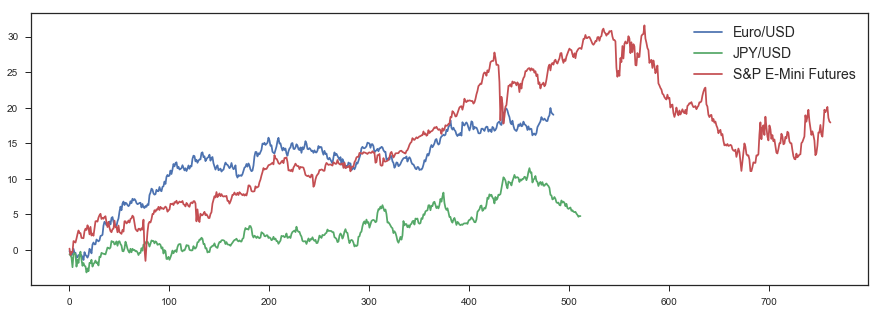

In [69]:
def best_indicatorSMALMA(n,prices,labels):
    #insert random walker function call and code here that simulates different windows for the rolling mean
    SMA,LMA = random_walkerSMALMA(n,"long",prices)
    SMAshort,LMAshort = random_walkerSMALMA(n,"short",prices)
    returns = back_testingSMALMA(prices,SMA,LMA,SMAshort,LMAshort) #plugs those here in place of 20/100
    print(SMA,LMA,SMAshort,LMAshort)
    plt.plot(np.cumsum(returns),label=labels)
    plt.legend(fontsize=14)
    return returns
plt.figure(figsize=(15,5))

euro_returns = best_indicatorSMALMA(100,euro,"Euro/USD")
#nflx_returns = best_indicator(150,nflx,"NFLX")
#intc_returns = best_indicator(100,intc)
jpy_returns = best_indicatorSMALMA(100,jpy,"JPY/USD")
#crude_returns = best_indicator(150,crude,"Crude")
e_mini_returns = best_indicatorSMALMA(10,e_mini,"S&P E-Mini Futures")
